# Thermal responses to pulse-like forcing changes

Comparison between two-layer and three-layer models

In [2]:
import numpy as np
import pandas as pd
from mce.core.forcing import RfCO2
from mce.core.climate import IrmBase
from mce.util.plot_base import PlotBase

In [3]:
myplt = PlotBase(palette='ipcc_wg1')

In [4]:
# Normalized CMIP data
with pd.HDFStore('data/cmip_normalized.h5', 'r') as store:
    df_norm = {
        'CMIP5':
        store['CMIP5/climate_norm1']
        .rename({'abrupt4xCO2': 'abrupt-4xCO2'}),
        'CMIP6':
        store['CMIP6/climate_norm1'],
    }

In [5]:
# Calibrated thermal parameters
with pd.HDFStore('data/parms_calib_climate.h5', 'r') as store:
    df_parms_nl2 = (
        store['cmip_norm1__nl2'] # 3-layer model
        .sort_index(key=lambda x: x.str.lower())
    )
    df_parms_nl3 = (
        store['cmip_norm1__nl3'] # 3-layer model
        .sort_index(key=lambda x: x.str.lower())
    )

In [6]:
class Driver(IrmBase):
    """Impulse response model driver
    """
    # Conversion factor for heat content change
    seconds_per_year = 3.15569e7
    earth_area = 5.10e14 # m^2
    conversion_factor = {
        # ('J/spy/m^2/y', 'ZJ/yr'): seconds_per_year * earth_area * 1e-21,
        ('J/spy/m^2', 'ZJ'): seconds_per_year * earth_area * 1e-21,
    }

    def __init__(self, nl, parms):
        """Create forcing and climate instances

        Parameters
        ----------
        nl
            Number of the climate model layers
        parms
            Thermal parameters
        """
        kw_forcing = {
            'alpha': parms['co2_alpha'],
            'beta': parms['co2_beta'],
        }
        kw_climate = {
            'asj': [parms[f'a{j}'] for j in range(nl)],
            'tauj': [parms[f'tau{j}'] for j in range(nl)],
            'lamb': parms['lambda'],
        }
        self.forcing = RfCO2(**kw_forcing)
        self.climate = IrmBase(nl, **kw_climate)
        _, self.xik, self.akj = self.climate.get_parms_ebm()

    def get_abrupt_xco2(self, time, xco2=4.):
        """Response to step increase forcing

        Parameters
        ----------
        time
            Time points in year
        xco2, optional
            Factor of CO2 concentration increase, by default 4.

        Returns
        -------
            Resulting DataFrame
        """
        erf = self.forcing.x2erf(xco2)
        lamb = self.climate.parms.lamb
        response = self.climate.response_ideal
        df = erf *  pd.DataFrame(
            [response(time, kind='step', variable='flux'),
             response(time, kind='step', variable='heat')
             * self.conversion_factor[('J/spy/m^2', 'ZJ')],
             response(time, kind='step', variable='tres') / lamb],
            index=['rtnt', 'thc', 'tas'],
            columns=time,
        )
        return df

    def get_1pctco2(self, time):
        """Response to 1%-per-year increase in CO2

        Parameters
        ----------
        time
            Time points in year

        Returns
        -------
            Resulting DataFrame
        """
        erf = self.forcing.x2erf(1.01**time)
        ret = self.climate.response(time, erf, akj=self.akj)
        tas = ret[:, 0]
        rtnt = erf - self.climate.parms.lamb * tas
        heat = (ret * self.xik).sum(axis=1)
        df = pd.DataFrame(
            [rtnt, heat*self.conversion_factor[('J/spy/m^2', 'ZJ')], tas],
            index=['rtnt', 'thc', 'tas'],
            columns=time,
        )
        return df

    def step2pulse(self, d_step, duration=1, interval=0):
        """Convert step response to pulse response by superposition

        Parameters
        ----------
        d_step
            Input step response
        duration, optional
            Pulse length in year, by default 1
        interval, optional
            Regular spacing of multiple pulses in year,
            by default 0, which means single pulse

        Returns
        -------
            Resulting DataFrame
        """
        d_pulse = d_step.sub(d_step.shift(duration))
        d_pulse.where(d_pulse.isna()==False, d_step, inplace=True)
        n = 1
        d1 = d_pulse.copy()
        if interval > 0:
            while 1:
                nst = n * interval
                if nst >= len(d_pulse):
                    break
                d1a = d_pulse.add(d1.shift(nst))
                d_pulse = d1a.where(d1a.isna()==False, d_pulse)
                n = n + 1
        return d_pulse

    def get_pulse_response(self, time, erf, duration=1, interval=0):
        """Response to pulse forcing

        Parameters
        ----------
        time
            Time points in year
        erf
            Forcing level in W m-2
        duration, optional
            Pulse length in year, by default 1
        interval, optional
            Regular spacing of multiple pulses in year,
            by default 0, which means single pulse

        Returns
        -------
            Resulting DataFrame
        """
        climate = self.climate

        tas = climate.response_ideal(time, kind='step', variable='tres')
        thc = climate.response_ideal(time, kind='step', variable='heat')
        df = pd.DataFrame(
            [
                tas / climate.parms.lamb,
                thc * self.conversion_factor[('J/spy/m^2', 'ZJ')],
            ],
            index=['tas', 'thc'], columns=time,
        ).mul(erf)

        df = df.transform(
            self.step2pulse, axis=1, duration=duration, interval=interval,
        )

        return df

    def get_pulse_peak(self, time, erf, duration, interval):
        """Peak responses to a series of regularly-spaced pulse forcing

        Parameters
        ----------
        time
            Time points in year
        erf
            Forcing level in W m-2
        duration
            Pulse length in year
        interval
            Spacing of multiple pulses in year

        Returns
        -------
            Resulting DataFrame
        """
        climate = self.climate
        akj = self.akj
        xik = self.xik
        tauj = climate.parms.tauj

        npulse = (time - duration) / interval + 1.
        bl = npulse == np.floor(npulse + 1e-6)
        # time[bl]: Time points when local peaks occur
        # npulse[bl]: Number of experienced pulses at local peaks

        # Peak response to single pulse
        d1 = akj * (1. - np.exp(-duration/tauj))
        # Dissipation factor after N pulses, calculated as
        # 1 + r + r**2 + ... + r**(n-1)
        r = np.exp(-(interval/tauj))
        d2 = (1. - r ** npulse[bl][:, None, None]) / (1. - r)

        # Sum of components in terms of time constants
        df = (d1 * d2).sum(axis=2)

        ## Changes in the surface temperature and the total heat content
        df = pd.DataFrame({
            'tas': df[:, 0],
            'thc':
            (df * xik[None, :]).sum(axis=1)
            * self.conversion_factor[('J/spy/m^2', 'ZJ')],
        }, index=time[bl]).T.mul(erf / climate.parms.lamb)

        return df

## Responses to idealized CO2 forcing changes

In [7]:
# Use IPSL-CM6A-LR as an example
mip, dataset = 'CMIP6', 'IPSL-CM6A-LR'
df = df_norm[mip].loc[dataset]

gcm = {
    ('4x', 'rtnt'): df.loc[('abrupt-4xCO2', 'rtnt')].dropna().values,
    ('4x', 'tas'): df.loc[('abrupt-4xCO2', 'tas')].dropna().values,
    ('1p', 'rtnt'): df.loc[('1pctCO2', 'rtnt')].dropna().values,
    ('1p', 'tas'): df.loc[('1pctCO2', 'tas')].dropna().values,
}
sca = Driver.conversion_factor[('J/spy/m^2', 'ZJ')]
gcm[('4x', 'thc')] = gcm[('4x', 'rtnt')].cumsum() * sca
gcm[('1p', 'thc')] = gcm[('1p', 'rtnt')].cumsum() * sca

time = np.arange(150) + 0.5

In [8]:
drv = Driver(2, df_parms_nl2.loc[(mip, dataset)])
df_irm2_4x = drv.get_abrupt_xco2(np.arange(151).astype('d'))
df_irm2_1p = drv.get_1pctco2(np.arange(141).astype('d'))

In [9]:
drv = Driver(3, df_parms_nl3.loc[(mip, dataset)])
df_irm3_4x = drv.get_abrupt_xco2(np.arange(151).astype('d'))
df_irm3_1p = drv.get_1pctco2(np.arange(141).astype('d'))

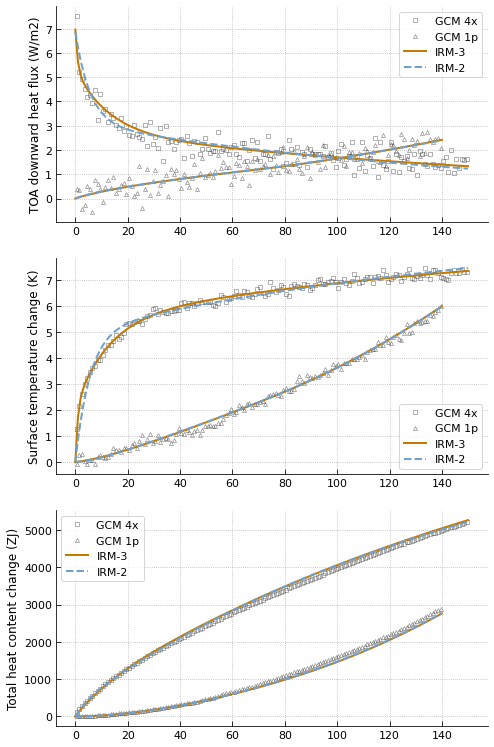

In [10]:
myplt.init_regular(
    3, kw_space={'height': 3., 'aspect': 2., 'hspace': 0.5},
)

kw_gcm = {
    'ls': 'None', 'mec': 'C0', 'mfc': 'none',
    'mew': 0.6, 'ms': 4, 'alpha': 0.5,
}
color_nl2 = 'C1'
color_nl3 = 'C2'
kw_irm2 = {'lw': 2., 'ls': '--', 'color': color_nl2}
kw_irm3 = {'lw': 2., 'color': color_nl3}

map_label = {
    'rtnt': 'TOA downward heat flux (W/m2)',
    'tas': 'Surface temperature change (K)',
    'thc': 'Total heat content change (ZJ)',
}

for n, vn in enumerate(['rtnt', 'tas', 'thc']):
    ax = myplt(n)

    ax.plot(time, gcm[('4x', vn)], label='GCM 4x', marker='s', **kw_gcm)
    ax.plot(time[:140], gcm[('1p', vn)], label='GCM 1p', marker='^', **kw_gcm)

    d1 = df_irm3_4x.loc[vn]
    ax.plot(d1.index, d1, label='IRM-3', **kw_irm3)
    d1 = df_irm2_4x.loc[vn]
    ax.plot(d1.index, d1, label='IRM-2', **kw_irm2)

    ax.legend()

    d1 = df_irm3_1p.loc[vn]
    ax.plot(d1.index, d1, label='IRM-3', **kw_irm3)
    d1 = df_irm2_1p.loc[vn]
    ax.plot(d1.index, d1, label='IRM-2', **kw_irm2)

    ax.set_ylabel(map_label[vn])
    ax.grid()

## Responses to a series of multiple pulses

Based on Gupta and Marshall (2018, https://doi.org/10.1175/JCLI-D-17-0703.1) regarding multiple volcanic eruptions

In [11]:
time = np.arange(60).astype('d')
erf1 = -1.
duration = 1
interval = 10

# Use IPSL-CM6A-LR as an example
mip, dataset = 'CMIP6', 'IPSL-CM6A-LR'

drv = Driver(2, df_parms_nl2.loc[(mip, dataset)])
df_2l = drv.get_pulse_response(time, erf1, duration, interval)
df_2l_peak = drv.get_pulse_peak(time, erf1, duration, interval)

drv = Driver(3, df_parms_nl3.loc[(mip, dataset)])
df_3l = drv.get_pulse_response(time, erf1, duration, interval)
df_3l_peak = drv.get_pulse_peak(time, erf1, duration, interval)

In [12]:
(
    np.allclose(df_2l_peak, df_2l[df_2l_peak.columns]),
    np.allclose(df_3l_peak, df_3l[df_3l_peak.columns]),
)

(True, True)

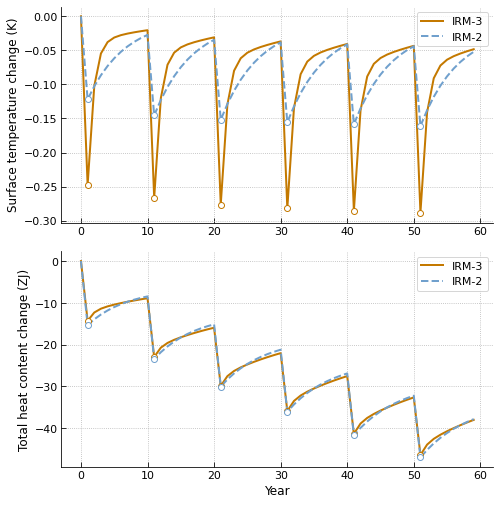

In [13]:
myplt.init_regular(2, kw_space={'aspect': 2., 'hspace': 0.4})

kw_marker = {'ls': 'None', 'marker': 'o', 'mfc': 'w'}

for n, vn in enumerate(['tas', 'thc']):
    ax = myplt(n)

    d1 = df_3l.loc[vn]
    ax.plot(d1.index, d1, label='IRM-3', **kw_irm3)
    d1 = df_2l.loc[vn]
    ax.plot(d1.index, d1, label='IRM-2', **kw_irm2)

    ax.legend()

    d1 = df_3l_peak.loc[vn]
    ax.plot(d1.index, d1, mec=color_nl3, **kw_marker)
    d1 = df_2l_peak.loc[vn]
    ax.plot(d1.index, d1, mec=color_nl2, **kw_marker)

    if n == 1:
        ax.set_xlabel('Year')

    ax.set_ylabel(map_label[vn])
    ax.grid()